## This page is under development...

I'm using yfinance package to download the stock data from yahoo finance. Then I will try predicting the prices for each stock. My goal is to make a prediction on the expected value and variance of the price based on the previous values. Then I'll try to compute the experimental covarience between different stocks and input them to an optimization problem designed to reduce the mixed variance while maximizing the expected output. This is based on the mean-volatility predicate in financial analysis.  
My initial intention was to use the rather new *tensorflow probability* capability to estimate the mean a variance for each output point. After some trials and failings, I have decided to use a simpler approach:
 - Use a small Nueral Net to compute a predicted value for the next days opening price for each stock.
 - Assume that my predictor assumes a normal distribution around the observed values (I should check this!). Therefore I can use the unbiased estimator of SD to find the expected variance around my predicted price.
 - Compute the correlations between different stocks experimentally (i.e. pairwise correlation between data columns)
 - perform the optimization as before.

In [58]:
import importlib
import single_stock_predictor
importlib.reload(single_stock_predictor)
import pickle
import yfinance as yf
import pandas as pd
import tensorflow as tf
import pickle
import numpy as np
#import mdn
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import h5py
from scipy.optimize import minimize

%matplotlib notebook

If running for first time, you need to downloaded the stock symbols or "tickers". This is in done by setting parameter  "get_tickers".<br> Currently I'm downloading the daily data for 9years. If you already have downloaded some part of the data you can download the rest and append them to each other. Later I hope to automatize this section, since my goal is to run this script once weekly or so.

In [44]:
get_tickers = False 
read_tickers = False
get_histories = False
get_updated_data = False
read_data = False
read_updated_data = True
get_business_info = True #you can go through business info field to exlude companies you don't want to invest in
if get_updated_data or get_business_info:
    read_tickers = True

In [45]:
def download_tickers():
    !curl -o /Users/abnousa/software/smartop/nasdaqtraded_companylist.txt ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqtraded.txt
    symbols = pd.read_csv("/Users/abnousa/software/smartop/nasdaqtraded_companylist.txt", sep = "|")
    symbols = symbols.iloc[0:(symbols.shape[0] - 1),:] #last row is time
    tickers = {}
    failed = []
    for i in symbols.index:
        sym = symbols.iloc[i]['Symbol']
        ticker = yf.Ticker(sym)
        try:
            check = ticker.calendar
        except Exception as e:
            print(' '.join(["disregarding", sym, type(e).__name__]))
            failed.append(sym)
            continue
        print(' '.join([sym, 'added']))
        name = symbols.iloc[i]['Security Name']
        tickers[sym] = {'name': name, 'ticker': ticker}
    sym_data = {'tickers':tickers, 'failed':failed}
    with open('sym_data.pkl', 'wb') as symfile:
        pickle.dump(sym_data, symfile)
    return(sym_data)
if get_tickers:
    sym_data = download_tickers()

In [624]:
#read_tickers = True
if read_tickers:
    with open('sym_data.pkl', 'rb') as symfile:
        sym_data = pickle.load(symfile)
        tickers, failed = sym_data['tickers'], sym_data['failed']

In [47]:
def download_business_info(tickers):
    for ticker in tickers.keys():
        #print(ticker)
        tickers[ticker]['business_summary'] = tickers[ticker]['ticker'].info.get('longBusinessSummary', None)
    with open('sym_data.pkl', 'wb') as symfile:
        pickle.dump(sym_data, symfile)
if get_business_info:
    download_business_info(tickers)

In [12]:
def download_histories(tickers):
    period = "9y"
    d = download_ticker_histories(tickers, period = period, interval = "1d", columns = ['Open'])
    with open("daily_history_9y.pkl", 'wb') as histfile:
        pickle.dump(d, histfile)
    return d
if get_histories:
    d = download_histories(sym_data['tickers'])

In [628]:
def download_ticker_histories(tickers, start = None, period = None, end = None, interval = "1d", columns = ['Open']):
    msft = yf.Ticker("MSFT")
    if start is None:
        temp_hist = msft.history(period="9y", interval="1d")
        end = list(temp_hist.index)[-1]
        start = list(temp_hist.index)[0]
    else:
        #print("downloading from", start)
        temp_hist = msft.history(start = start, interval = "1d")
        #print(temp_hist)
        end = list(temp_hist.index)[-1] 
        end = None
        #print(end + 1)
    d = yf.download(" ".join(list(tickers.keys())), start = last_date, end = end, interval = '1d', threads = False)[columns]
    return d

In [4]:
if read_data:
    with open("daily_history_9y.pkl", 'rb') as infile:
        d = pickle.load(infile)

In [629]:
def update_data(d, tickers, columns = ['Open']):
    last_date = (pd.to_datetime(d.index.values[-1])).strftime("%Y-%m-%d")
    d_update = download_ticker_histories(tickers, start = last_date, interval = "1d", columns = columns)
    d_update = d_update.iloc[1:,:]
    #d_update.head()
    d_merged = pd.concat([d, d_update], axis = 0)
    with open("daily_history_updated.pkl", 'wb') as histfile:
        pickle.dump(d_merged, histfile)
    return d_merged
if get_updated_data:
    d = update_data(d, tickers, columns = ['Open'])

- ABIL: No data found for this date range, symbol may be delisted
ADX
- AFGE: No data found for this date range, symbol may be delisted
AIV
- ALAC: No data found for this date range, symbol may be delisted
- AMCI: No data found for this date range, symbol may be delisted
AMRX
- ANDA: No data found for this date range, symbol may be delisted
- ANDAU: No data found for this date range, symbol may be delisted
- ANFI: No data found for this date range, symbol may be delisted
ARES
- ARTX: No data found for this date range, symbol may be delisted
AUMN
- AVP: No data found for this date range, symbol may be delisted
BBBY
- BBIN: No data found for this date range, symbol may be delisted
BH
- BKJ: No data found for this date range, symbol may be delisted
BNDX
- BNTCW: No data found for this date range, symbol may be delisted
- BRQS: No data found for this date range, symbol may be delisted
BSM
- BUY: No data found for this date range, symbol may be delisted
- BUYN: No data found for this date r

KeyboardInterrupt: 

In [51]:
if read_updated_data:
    with open("daily_history_updated.pkl", 'rb') as infile:
        d = pickle.load(infile)

<IPython.core.display.Javascript object>


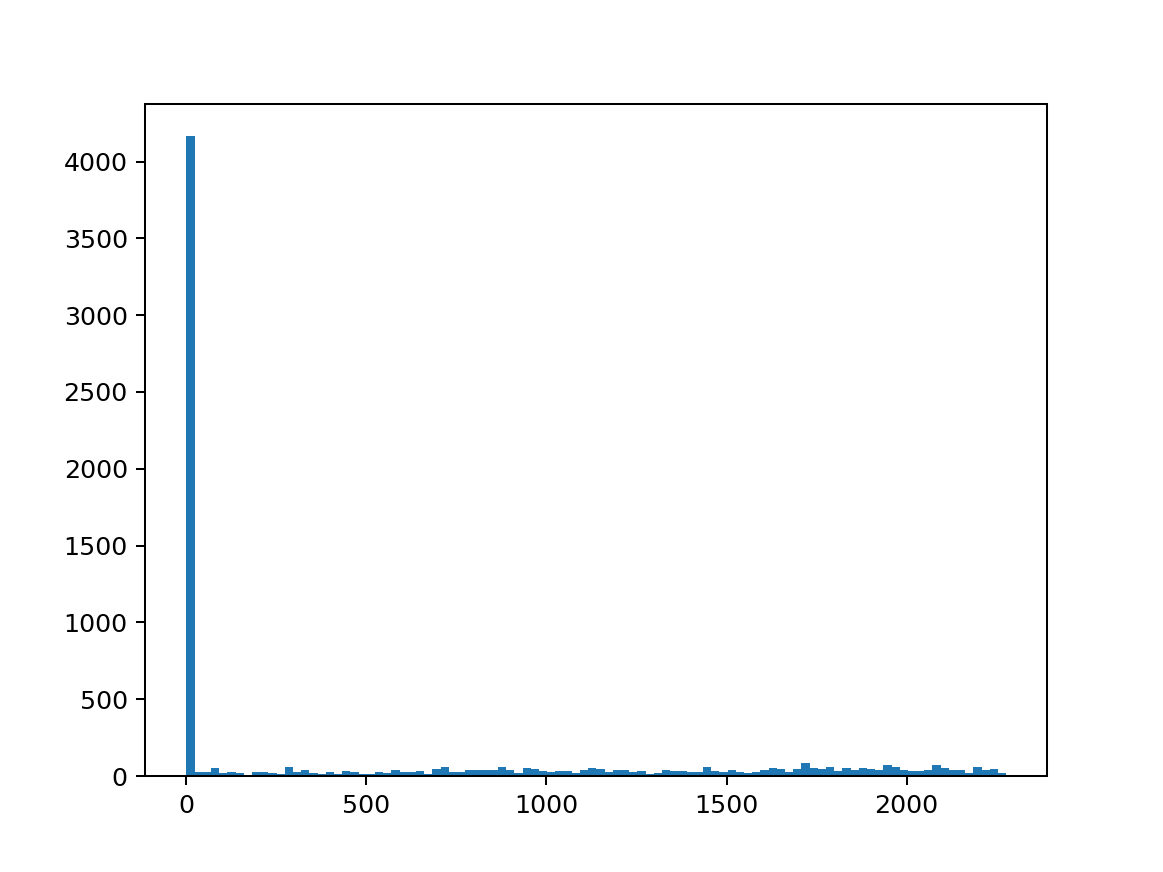

(array([4166.,   28.,   25.,   52.,   18.,   23.,   22.,    9.,   23.,
          24.,   21.,   10.,   56.,   23.,   39.,   21.,   13.,   26.,
          14.,   32.,   27.,   13.,   14.,   28.,   21.,   36.,   26.,
          27.,   34.,   16.,   47.,   60.,   24.,   24.,   40.,   38.,
          37.,   37.,   56.,   39.,   22.,   53.,   48.,   30.,   24.,
          34.,   35.,   19.,   41.,   51.,   45.,   23.,   40.,   38.,
          27.,   31.,   14.,   22.,   39.,   30.,   33.,   29.,   23.,
          59.,   32.,   24.,   39.,   27.,   20.,   28.,   42.,   52.,
          46.,   25.,   45.,   84.,   52.,   46.,   57.,   30.,   54.,
          42.,   53.,   46.,   37.,   70.,   60.,   40.,   31.,   35.,
          41.,   69.,   55.,   39.,   37.,   18.,   56.,   38.,   43.,
          19.]),
 array([   0.  ,   22.77,   45.54,   68.31,   91.08,  113.85,  136.62,
         159.39,  182.16,  204.93,  227.7 ,  250.47,  273.24,  296.01,
         318.78,  341.55,  364.32,  387.09,  409.86,  432.63

In [108]:
plt.figure()
plt.hist(d.isna().sum(), bins = 100)

In [109]:
#backward-filling na's 
d = d.iloc[:, list(np.where(d.isna().sum() < 20)[0])]
d = d.fillna(method = "bfill")
d.shape

(2277, 4164)

In [110]:
#removing rows where the latest price is na
d = d.loc[:, ~(d.iloc[d.shape[0] - 1,:].isna())]
d.shape

(2277, 4090)

In [79]:
import single_stock_predictor
importlib.reload(single_stock_predictor)

<module 'single_stock_predictor' from '/Users/abnousa/software/smartr/single_stock_predictor.py'>

In [63]:
stock_name = "BMRA"
weekly = False
window_size = 30
batch_size = 32
shuffle_buffer = None
distributional = False
epochs = 40
training_points = 1500
model_sd_estimate_required = True
model_outdir = "models"
training_verbosity = 1
look_ahead_window = 5
pred, train_sd, valid_sd, model_train_sd, train_forecasts, model_valid_sd, valid_forecasts = single_stock_predictor.predict_tomorrow(stock_name, d, model_outdir = model_outdir, weekly = weekly, training_points = training_points, window_size = window_size, batch_size = batch_size, distributional = distributional, epochs = epochs, model_sd_estimate_required = model_sd_estimate_required, shuffle_buffer = shuffle_buffer, training_verbosity = training_verbosity, look_ahead_window = look_ahead_window)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 30, 128)           16640     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 49,665
Trainable params: 49,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
46/46 [==============================] - 3s 75ms/step - loss: 0.0557 - val_loss: 0.0000e+00
Epoch 2/40
46/46 [==============================] - 2s 34ms/step - loss: 0.0132 - val_loss: 0.0536
Epoch 3/40
46/46 [==============================] - 1s 28ms/step - loss: 0.0139 - val_loss: 0.0689
Epoch 4/40
46/46 [==============================] - 1s 29ms/step - loss: 0.0145 -

<IPython.core.display.Javascript object>


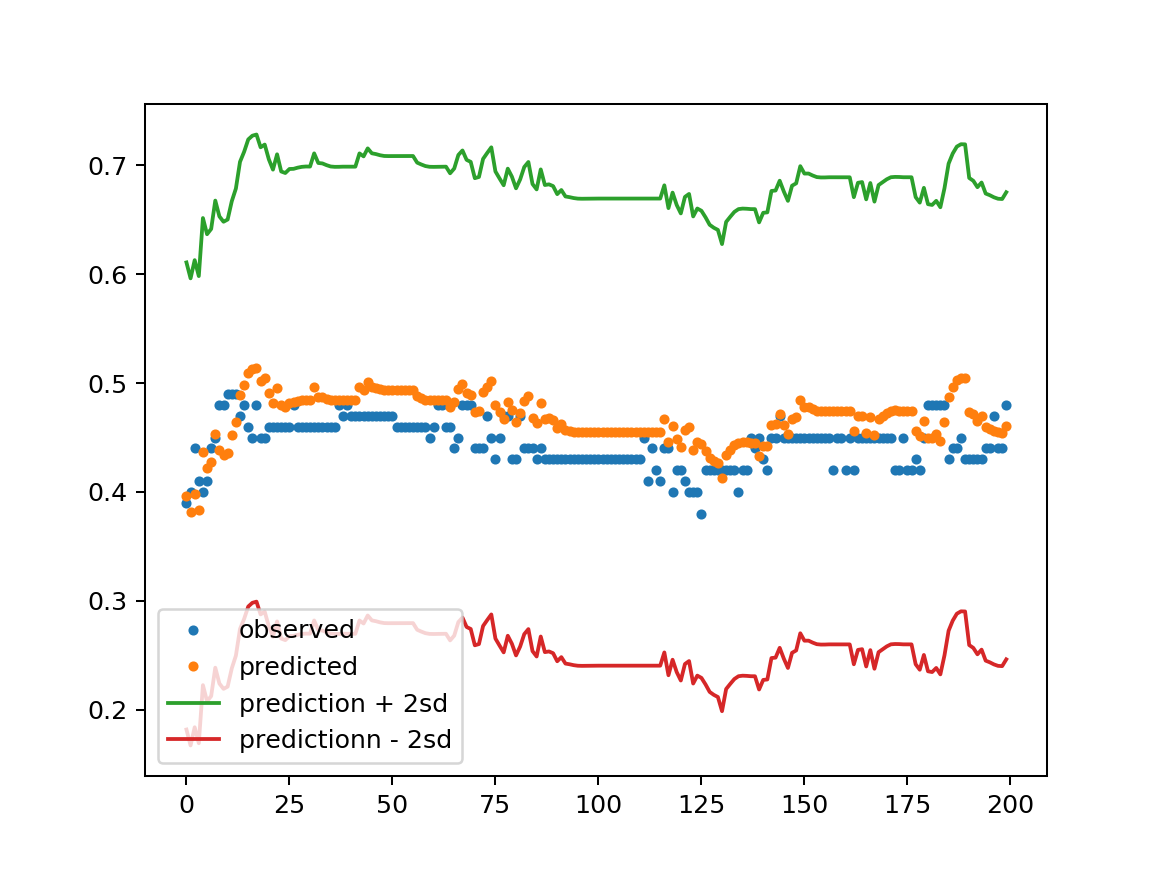

In [68]:
plt.figure()
single_stock_predictor.plot_predictions(d[stock_name], train_forecasts, model_train_sd, window_size, limit_begin = 0, limit_end = 200, look_ahead_window = look_ahead_window)

<IPython.core.display.Javascript object>


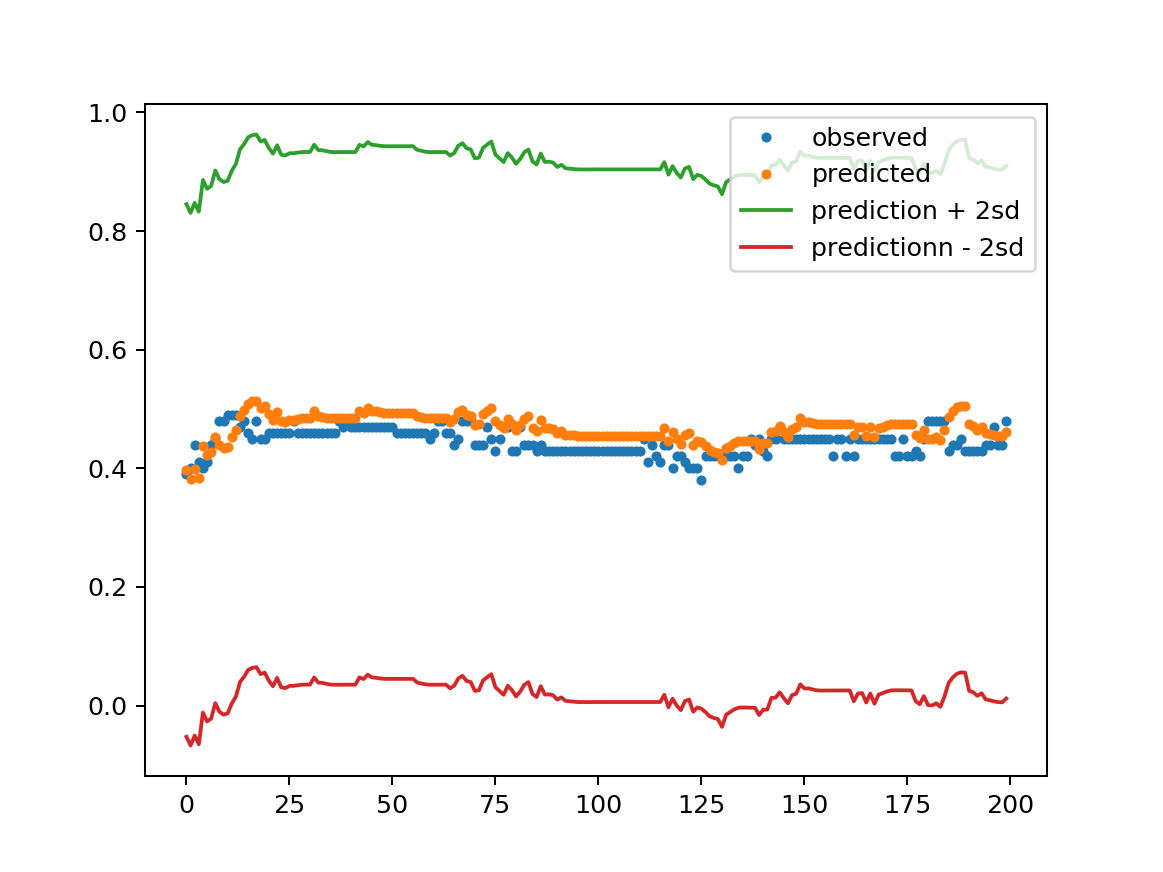

In [71]:
plt.figure()
single_stock_predictor.plot_predictions(d[stock_name], train_forecasts, model_valid_sd, window_size, limit_begin = 0, limit_end = 200, look_ahead_window = look_ahead_window)

<IPython.core.display.Javascript object>


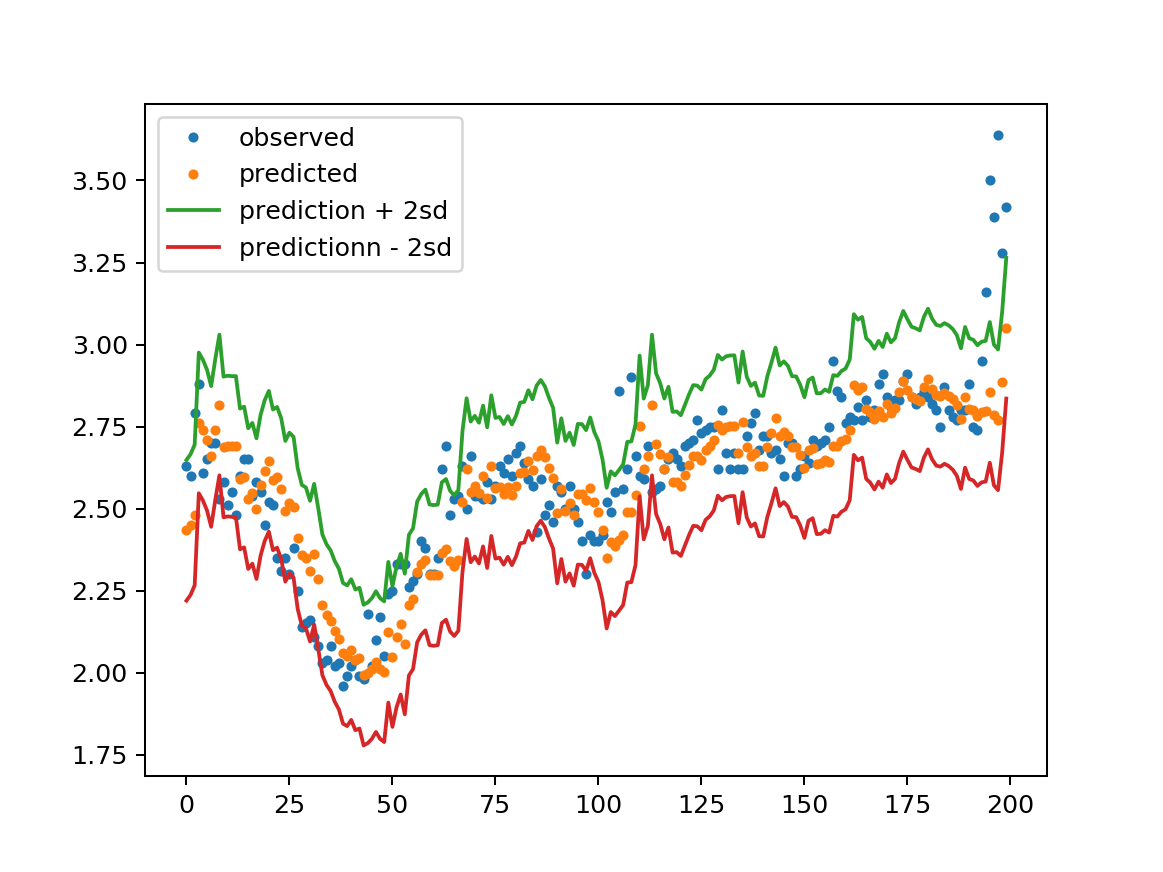

In [74]:
plt.figure()
single_stock_predictor.plot_predictions(d[stock_name][training_points:], valid_forecasts, model_train_sd, window_size, limit_begin = 0, limit_end = 200, look_ahead_window = look_ahead_window)

<IPython.core.display.Javascript object>


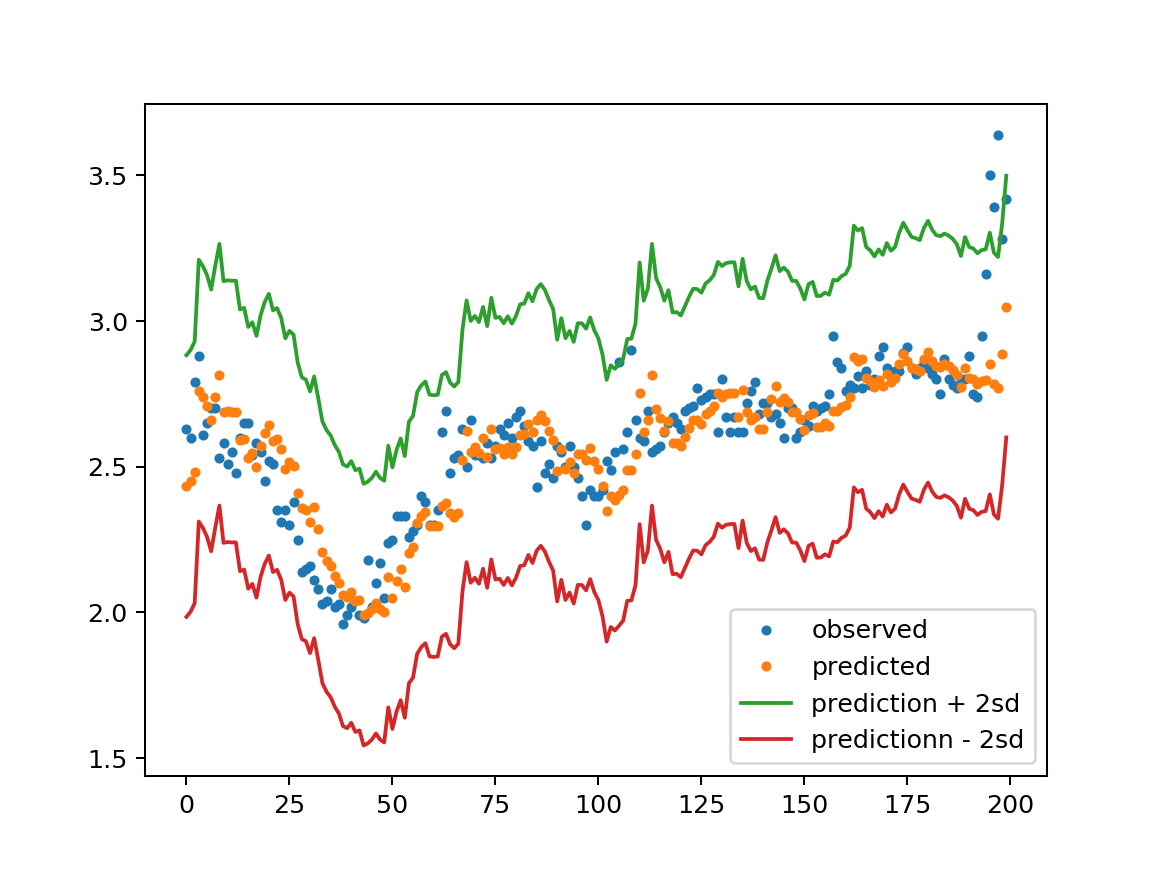

In [95]:
plt.figure()
single_stock_predictor.plot_predictions(d[stock_name][training_points:], valid_forecasts, model_valid_sd, window_size, limit_begin = 0, limit_end = 200, look_ahead_window = look_ahead_window)

okay, so far we have showed that for the specified stock (here, MSFT aka microsoft) our model generates rather dependable predictions of price and our estimated standard deviation seems to be fitting at least visually. Of course, one can argue that we have picked an easy ticker, you'd expect microsoft to have a stable price. Well, I can't argue against that. But now, I'm going to randomly pick 10 tickers and perform the same operation on each of them. Before that I
m going to use the *cov()* function from pandas to compute pairwise correlation between the selected tickers.

In [113]:
import random
ticker_set = random.sample(list(d.columns), 10)
ticker_set

['CGEN', 'EXK', 'SRT', 'SCHB', 'MO', 'GEL', 'EVRI', 'PMBC', 'IEO', 'CCCL']

In [114]:
d_select = d[ticker_set]
covariances = d_select.cov()
covariances.head()
correlations = d_select.corr()

<IPython.core.display.Javascript object>


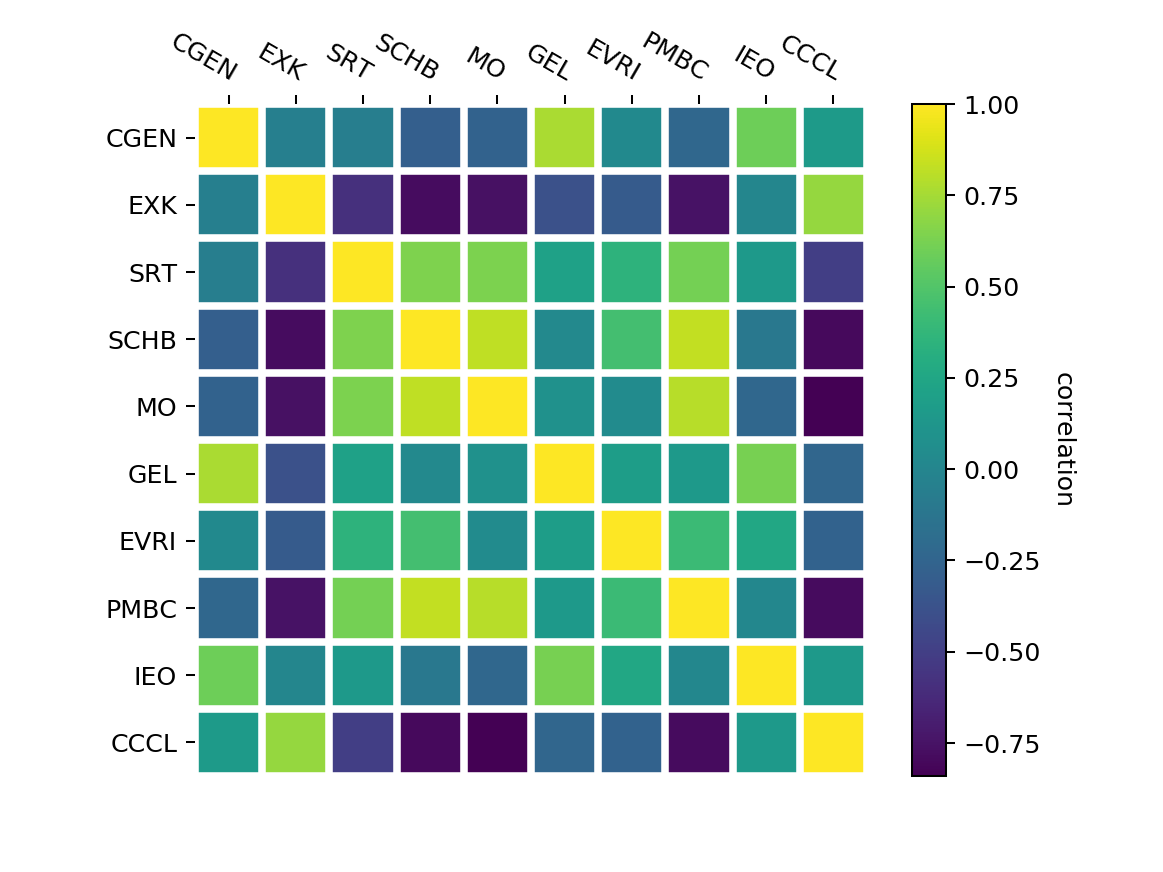

(<matplotlib.image.AxesImage at 0x14ee82470>,
 <matplotlib.colorbar.Colorbar at 0x14eeabac8>)

In [115]:
plt.figure()
corels_matrix = np.array(correlations)
single_stock_predictor.heatmap(corels_matrix, correlations.columns.values, correlations.columns.values, cbarlabel = "correlation")

In [112]:
weekly = False
window_size = 30
batch_size = 32
shuffle_buffer = None
distributional = False
epochs = 10
training_points = 1500
model_sd_estimate_required = True
model_outdir = "models"
look_ahead_window = 5
training_verbosity = 0

In [116]:
prediction_dict = {}
for stock_name in ticker_set:
    print(" ".join(["processing", stock_name]))
    pred, train_sd, valid_sd, model_train_sd, train_forecasts, model_valid_sd, valid_forecasts = single_stock_predictor.predict_tomorrow(stock_name, d, model_outdir = model_outdir, weekly = weekly, training_points = training_points, window_size = window_size, batch_size = batch_size, distributional = distributional, epochs = epochs, model_sd_estimate_required = model_sd_estimate_required, shuffle_buffer = shuffle_buffer, training_verbosity = training_verbosity, look_ahead_window = look_ahead_window)
    prediction_dict[stock_name] = {'expected_tomorrow': pred,
                                   'model_train_sd': model_train_sd,
                                   'train_forecasts': train_forecasts,
                                   'model_valid_sd': model_valid_sd,
                                   'valid_forecasts': valid_forecasts}
    current_price = d.iloc[d.shape[0]-1][stock_name]
    return_rate = pred / current_price - 1
    prediction_dict[stock_name]['return_rate'] = return_rate

processing CGEN
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 30, 128)           16640     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 49,665
Trainable params: 49,665
Non-trainable params: 0
_________________________________________________________________
processing EXK
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 30, 128)           16640     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               32896     
_

It looks like for a few of the stocks, validation error was smaller than the training error. I'm curious why.

So here are the plots from validation data:

<IPython.core.display.Javascript object>


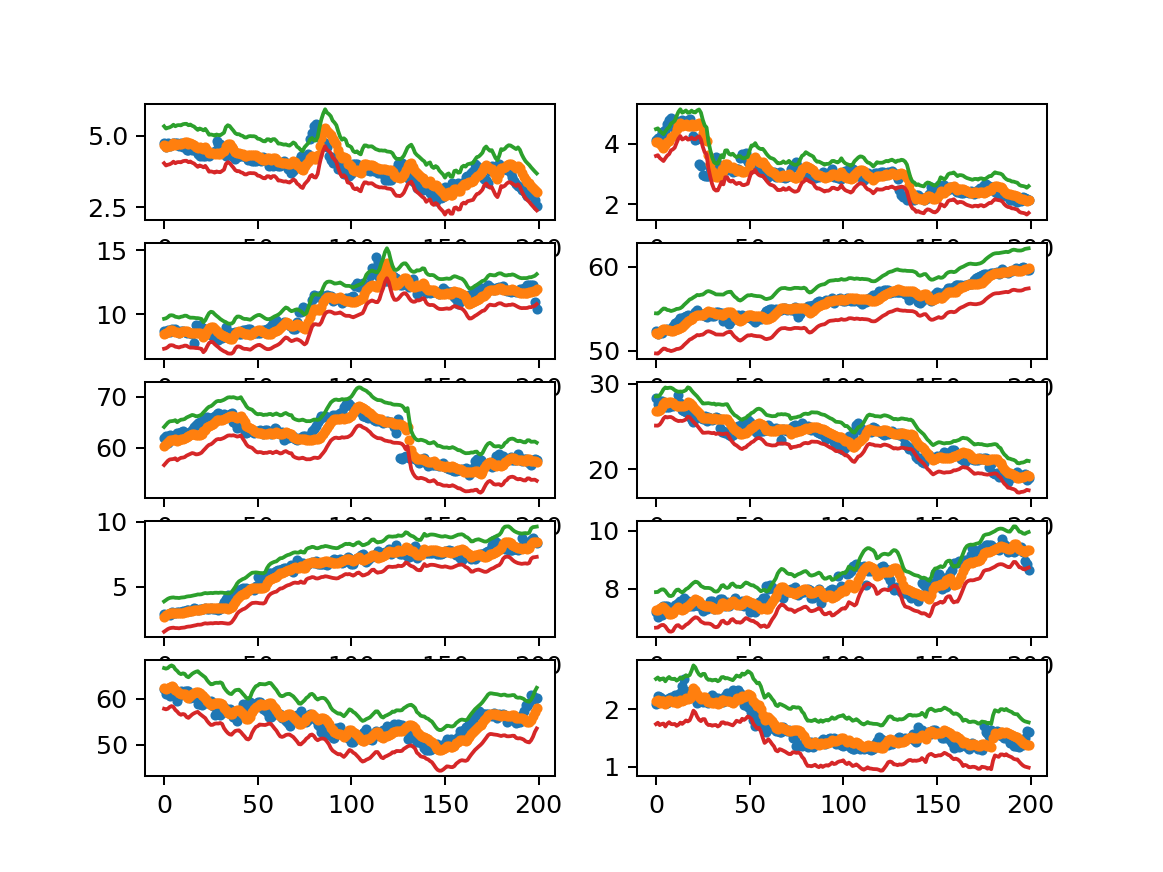

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [117]:
plt.figure()
plt.subplot(5,2,1)
for plt_index, stock_name in enumerate(ticker_set):
    ax = plt.subplot(5,2,plt_index + 1)
    single_stock_predictor.plot_predictions(d[stock_name][training_points:], prediction_dict[stock_name]['valid_forecasts'], prediction_dict[stock_name]['model_valid_sd'], window_size, limit_begin = 0, limit_end = 200, ax = ax, legend = False, look_ahead_window = look_ahead_window)        

and here are plots for training data:

<IPython.core.display.Javascript object>


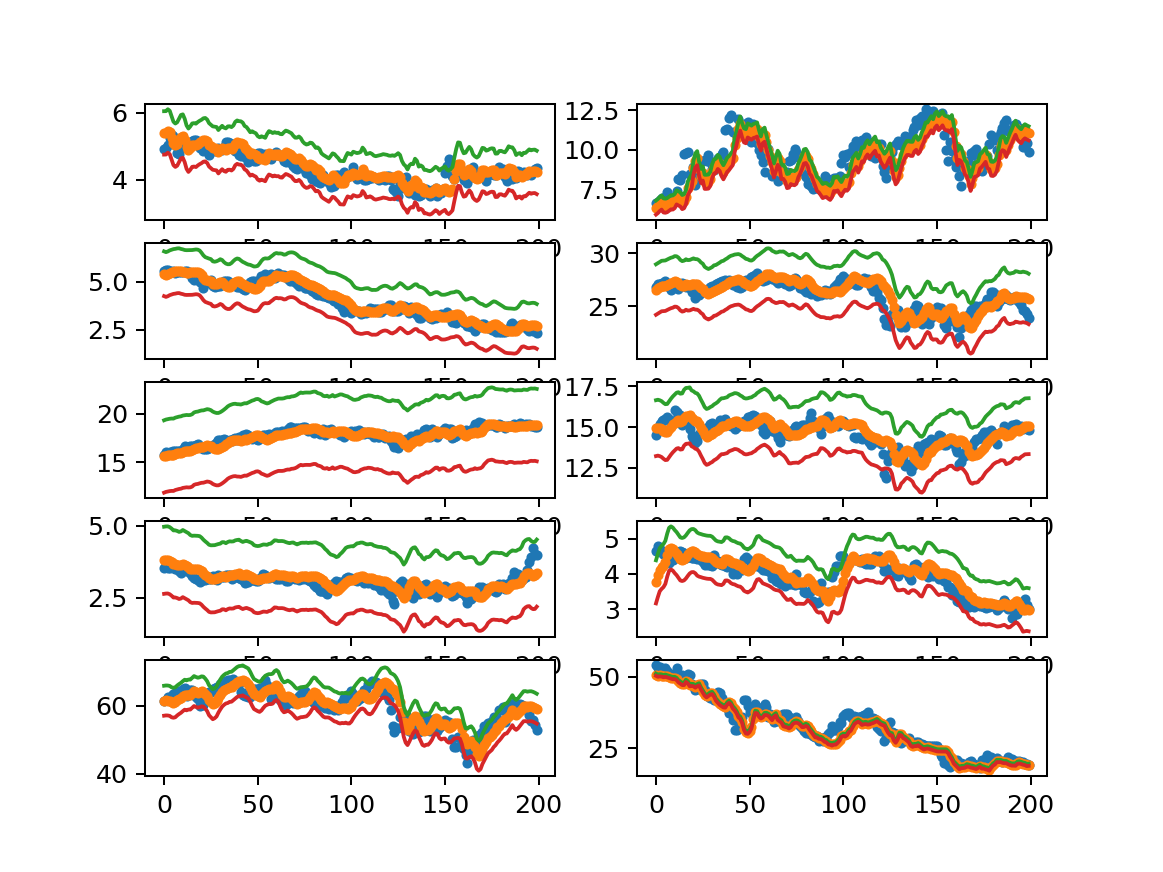

In [118]:
plt.figure()
plt.subplot(5,2,1)
for plt_index, stock_name in enumerate(ticker_set):
    ax = plt.subplot(5,2,plt_index + 1)
    single_stock_predictor.plot_predictions(d[stock_name], prediction_dict[stock_name]['train_forecasts'], prediction_dict[stock_name]['model_valid_sd'], window_size, limit_begin = 0, limit_end = 200, ax = ax, legend = False, look_ahead_window = look_ahead_window)

In [ ]:
for stock_name in ticker_set:
    pred = prediction_dict[stock_name]['expected_tomorrow']
    current_price = d.iloc[d.shape[0] - 1, :][stock_name]
    return_rate = pred / current_price - 1
    prediction_dict[stock_name]['return_rate'] = return_rate

In [ ]:
rat_risks = pd.DataFrame({'return_rate':[prediction_dict[stock_name]['return_rate'] for stock_name in ticker_set],
                        'risk' : [prediction_dict[stock_name]['valid_sd'] for stock_name in ticker_set],
                         'price': d.iloc[d.shape[0] - 1][ticker_set]})

In what follows I'll be minimzing the mixed variance by selecting the "best" portfolio for a given return rate and budjet. For the optimization part I have heavily been dependent on the codes in [this tutorial](https://towardsdatascience.com/efficient-frontier-optimize-portfolio-with-scipy-57456428323e). Kudos to **J Li**. I have modified the code to compute the portfolio risk from linear combination of standard deviations. Later I will also modify the optimization function by adding new constraints to compute the number of shares to buy with a given budget rather than the weight of instruments in the portfolio.

variance of a linear combination of random variable can be computed by the formula below: [(source)](https://en.wikipedia.org/wiki/Variance)
<img src="ext/lincomb_variance.png" style="height:200px">

In [119]:
#ticker_set = [name for name in candidates if name in list(d.columns.values)]
rat_risks = pd.read_csv("rates_and_risks.csv")
rat_risks.head()
rat_risks = rat_risks[rat_risks['name'] != "stock"]
print(rat_risks.shape)
rat_risks.head()

(387, 5)


,price,train_sd,name,valid_sd,prediction
0,87.720001,1.200346,A,2.183677,87.043076
1,27.959999,1.668038,AAL,1.924209,27.978212
2,1.920000,0.147755,AAME,0.172343,1.903574
3,50.740002,0.773315,AAON,1.704607,50.628757
4,9.780000,1.094189,ADTN,0.871396,9.948958


In [120]:
rat_risks['return_rate'] = (rat_risks['prediction'] - rat_risks['price'])/rat_risks['price']
rat_risks.head()

,price,train_sd,name,valid_sd,prediction,return_rate
0,87.720001,1.200346,A,2.183677,87.043076,-0.007717
1,27.959999,1.668038,AAL,1.924209,27.978212,0.000651
2,1.920000,0.147755,AAME,0.172343,1.903574,-0.008555
3,50.740002,0.773315,AAON,1.704607,50.628757,-0.002192
4,9.780000,1.094189,ADTN,0.871396,9.948958,0.017276


(array([380.,   3.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([-0.04080404,  0.30791737,  0.65663879,  1.0053602 ,  1.35408161,
         1.70280303,  2.05152444,  2.40024586,  2.74896727,  3.09768869,
         3.4464101 ]),
 <a list of 10 Patch objects>)

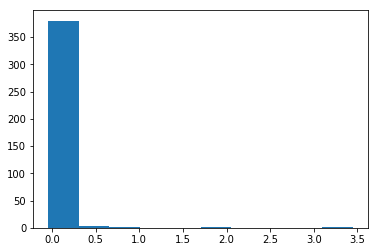

In [657]:
plt.hist(rat_risks['return_rate'])

In [729]:
ticker_set = rat_risks['name']
#rat_risks[rat_risks['return_rate']>3]

<IPython.core.display.Javascript object>


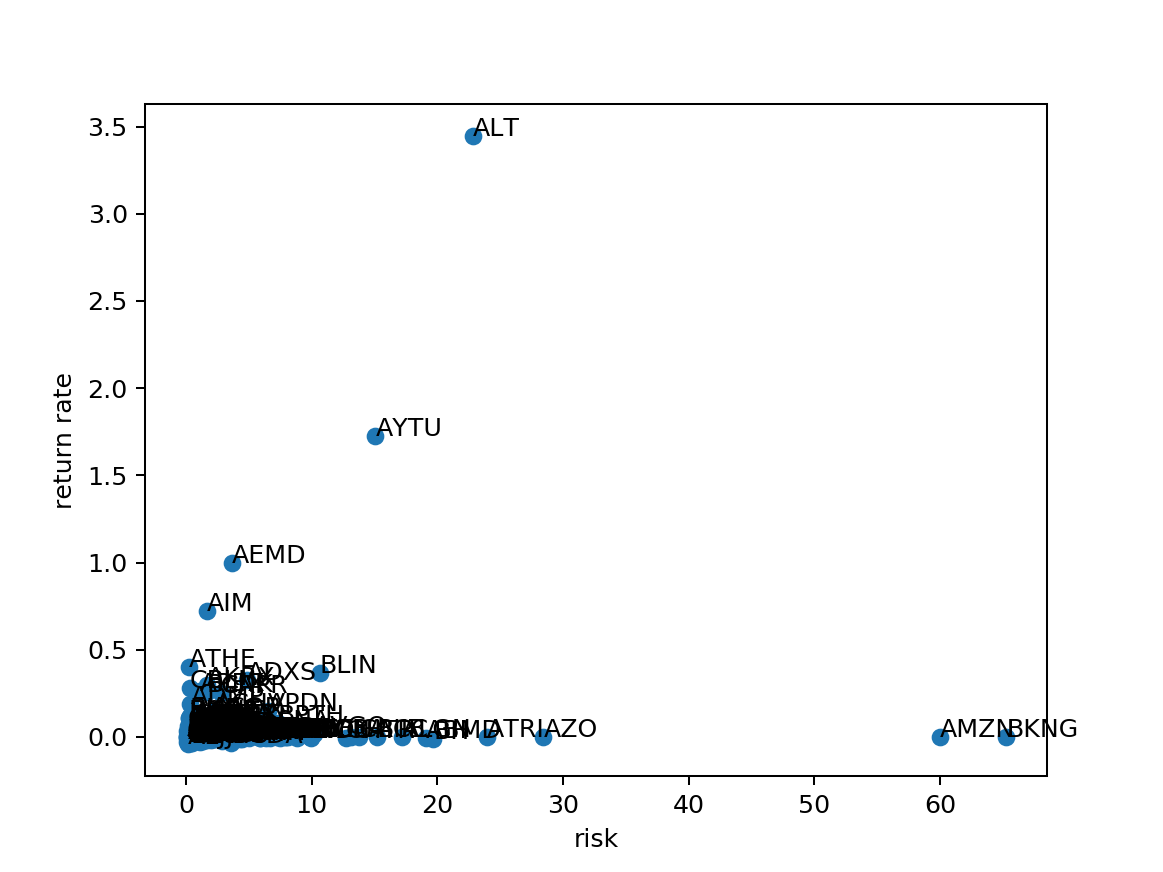

In [731]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.scatter(rat_risks['valid_sd'], rat_risks['return_rate'])
for stock_name in ticker_set:
    ax.annotate(stock_name, (rat_risks[rat_risks['name'] == stock_name]['valid_sd'], rat_risks[rat_risks['name'] == stock_name]['return_rate']))
plt.xlabel("risk")
plt.ylabel("return rate")
plt.show()

In [667]:
def get_portfolio_risk(weights, rat_risks, covariances):
    weight_matrix = np.outer(weights , weights)
    weight_cov_combined = covariances * weight_matrix
    mixed_var = np.sum(np.sum(weight_cov_combined))
    return mixed_var

def get_portfolio_return(weights, rat_risks):
    total_return_rate = np.sum(rat_risks['return_rate'] * weights)
    return total_return_rate

In [732]:
def optimize_weights(rat_risks, target_return=0.1):
    instruments_count = rat_risks.shape[0]
    init_guess = np.zeros(instruments_count) * (1.0 / instruments_count)
    #print(init_guess)
    bounds = ((0.0, 1.0),) * instruments_count
    weights = minimize(get_portfolio_risk, init_guess,
                       args=(rat_risks, covariances), method='SLSQP',
                       options={'disp': True, 'maxiter' : 100},
                       constraints=({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)},
                                    {'type': 'eq', 'args': (rat_risks,),
                                     'fun': lambda inputs, rat_risks:
                                     target_return - get_portfolio_return(weights=inputs,
                                                                          rat_risks=rat_risks)}
                                   ),
                       bounds=bounds)
    return weights.x, weights.success, weights.status, weights.message

In [758]:
d_select = d[rat_risks['name']]
covariances = d_select.cov()
weights, success, status, message = optimize_weights(rat_risks, target_return = 0.08)
print(get_portfolio_risk(weights, rat_risks, covariances))
print(success)
print(status)
print(message)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.045684945890603845
            Iterations: 37
            Function evaluations: 14457
            Gradient evaluations: 37
0.045684945890603845
True
0
Optimization terminated successfully.


In [742]:
#results = pd.DataFrame()
for desired_rate in np.arange(0.1,0.16, 0.01):
    print(desired_rate)
    weights, success, status, message = optimize_weights(rat_risks, target_return = desired_rate)
    cur_risk = get_portfolio_risk(weights, rat_risks, covariances)
    results = pd.concat([results, pd.DataFrame({'return': [desired_rate], 'risk': [cur_risk],
                                             'success': [success], 'message' : [message]})], axis = 0)

0.1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.08060663695467338
            Iterations: 37
            Function evaluations: 14453
            Gradient evaluations: 37
0.11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.10670008520291072
            Iterations: 38
            Function evaluations: 14840
            Gradient evaluations: 38
0.12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.14124989198173243
            Iterations: 37
            Function evaluations: 14453
            Gradient evaluations: 37
0.13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.18667994991435424
            Iterations: 37
            Function evaluations: 14454
            Gradient evaluations: 37
0.13999999999999999
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.24593357

In [743]:
results

,return,risk,success,message
0,0.02,0.005802,True,Optimization terminated successfully.
0,0.03,0.008796,True,Optimization terminated successfully.
0,0.04,0.012982,True,Optimization terminated successfully.
0,0.05,0.018647,True,Optimization terminated successfully.
0,0.06,0.025835,True,Optimization terminated successfully.
0,0.07,0.034737,True,Optimization terminated successfully.
0,0.08,0.045685,True,Optimization terminated successfully.
0,0.09,0.060532,True,Optimization terminated successfully.
0,0.10,0.080607,True,Optimization terminated successfully.
0,0.11,0.106700,True,Optimization terminated successfully.


<IPython.core.display.Javascript object>


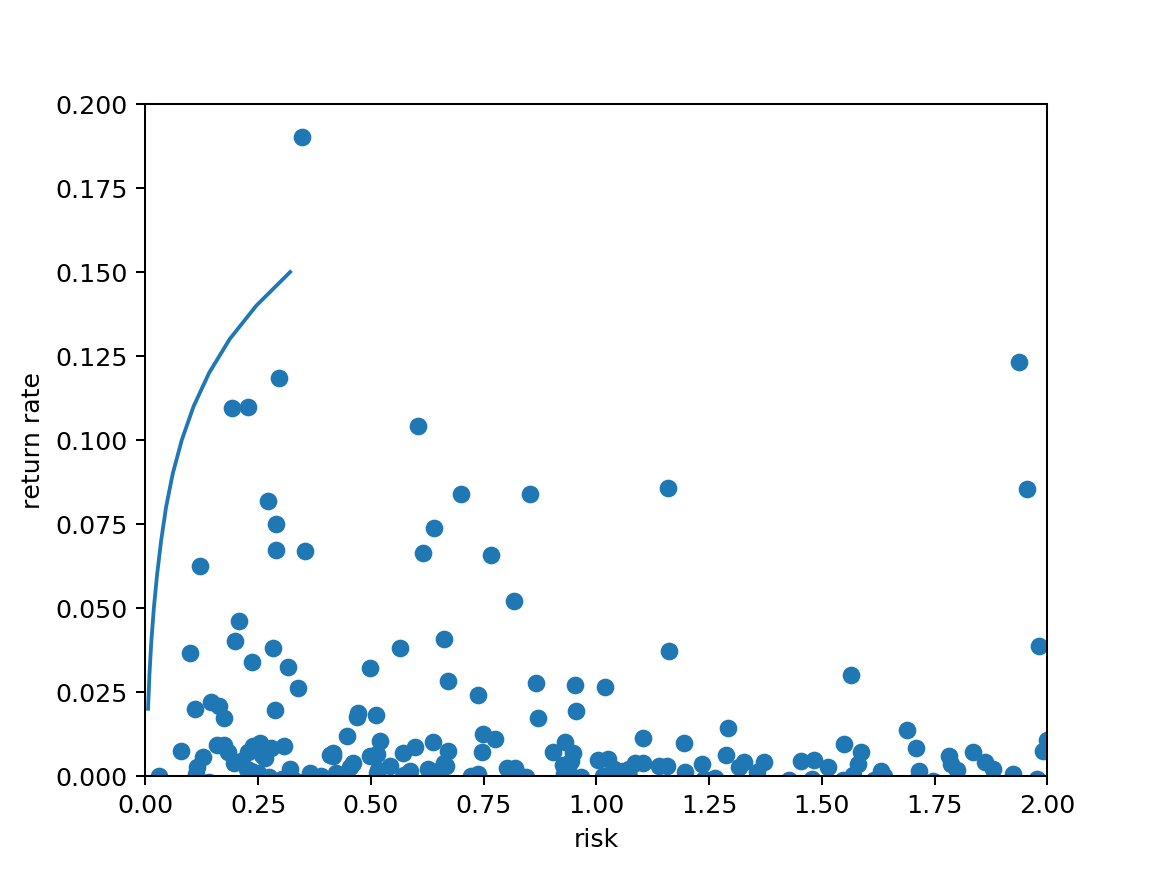

In [744]:
fig, ax = plt.subplots()
ax.scatter(rat_risks['valid_sd'], rat_risks['return_rate'])
#for stock_name in ticker_set:
#    ax.annotate(stock_name, (rat_risks[rat_risks['name'] == stock_name]['valid_sd'], rat_risks[rat_risks['name'] == stock_name]['return_rate']))
plt.plot(results['risk'], results['return'])
plt.xlabel("risk")
plt.ylabel("return rate")
plt.ylim(0,0.2)
plt.xlim(0,2)
plt.show()

In [721]:
d['ATHE'].tail()

Date
2020-01-06    0.8000
2020-01-07    0.8500
2020-01-08    0.8100
2020-01-09    0.8300
2020-01-10    0.8141
Name: ATHE, dtype: float64

In [722]:
rat_risks[rat_risks['name'] == "ATHE"]

,price,train_sd,name,valid_sd,prediction,return_rate
129,0.8141,4.467148,ATHE,0.24394,1.140323,0.400716


In [ ]:
fig, ax = plt.subplots()
ax.scatter(rat_risks['risk'], rat_risks['return_rate'])
for i, stock_name in enumerate(ticker_set):
    ax.annotate(' '.join([stock_name, str(round(weights[i], 5))]), (prediction_dict[stock_name]['valid_sd'], prediction_dict[stock_name]['return_rate']))
plt.title("weigth of each instrument for minimized risk for 0.1 return rate")
plt.xlabel("risk")
plt.ylabel("rate of return")
plt.show()

The weights seem to make sense, with the instruments with higher risk getting a weight of zero and the ones with higher return rate and small risk getting the largest of weights. 
Now let's modify the optimization function to accept and budget constraint as well as output number of shares per instrument (integer) rather than weights.

In [745]:
def get_portfolio_risk_by_shares(shares, rat_risks, covariances):
    weights = shares / np.sum(shares)
    weight_matrix = np.outer(weights , weights)
    weight_cov_combined = covariances * weight_matrix
    mixed_var = np.sum(np.sum(weight_cov_combined))
    return mixed_var

def get_portfolio_return_by_shares(shares, rat_risks, budget):
    spent = np.sum(rat_risks['price'] * shares)
    unspent = budget - spent
    returns = spent * np.sum(rat_risks['return_rate'] * shares) + unspent
    total_return_rate = (returns/budget) - 1
    return total_return_rate

def budget_constraint(shares, rat_risks, budget):
    prices = np.array(rat_risks['price'])
    unspent = budget - np.sum(shares * prices)
    return(unspent)

In [772]:
def optimize_shares(rat_risks, target_return=0.1, budget = 2000):
    #normalized_prices = prices / prices.ix[0, :]
    instruments_count = rat_risks.shape[0]
    init_guess = np.ones(instruments_count) #(1.0 / instruments_count)
    bounds = ((0.0, np.inf),) * instruments_count
    shares = minimize(get_portfolio_risk_by_shares, init_guess,
                       args=(rat_risks, covariances), method='SLSQP',
                       options={'disp': True, 'maxiter': 1000},
                       constraints=({'type': 'ineq', 'fun': lambda x: budget_constraint(x, rat_risks, budget)}, #make sure total is less than budget
                                    {'type': 'eq', 'args': (rat_risks, budget), #make the return rate equal to the expected rate
                                     'fun': lambda inputs, rat_risks, budget:
                                     target_return - get_portfolio_return_by_shares(inputs, rat_risks, budget)},
                                    {'type':'eq','fun': lambda x : max([0] + [x[i]-int(x[i]) for i in range(len(x)) if x[i]-int(x[i]) > 0])}, #try to make them as close to integer as possible
                                   ),
                       bounds=bounds
                     )
    return shares.x, shares.success, shares.status, shares.message

In [773]:
budget = 1000
share_distribution, success, status, message = optimize_shares(rat_risks, budget = budget, target_return = 0.08)
share_distribution
rat_risks['shares'] = np.floor(share_distribution)

More than 3*n iterations in LSQ subproblem    (Exit mode 3)
            Current function value: 1.7136813251079932
            Iterations: 801
            Function evaluations: 316028
            Gradient evaluations: 800


In [778]:
rat_risks.sort_values(['shares', 'weights', 'price'], ascending = False).head(20)

,price,train_sd,name,valid_sd,prediction,return_rate,shares,weights
64,2.420000,0.164238,AMS,0.174464,2.461890,0.017310,159.0,1.928066e-14
257,2.240000,0.618777,BOSC,0.141905,2.236231,-0.001683,159.0,8.662754e-15
33,1.335000,0.173608,ALJJ,0.145194,1.280527,-0.040804,121.0,6.437517e-15
214,0.970000,0.184147,BGI,0.110559,0.989476,0.020078,32.0,1.534238e-14
272,1.428800,0.524874,BSQR,0.228496,1.585582,0.109730,21.0,5.371407e-02
204,0.783750,0.117739,BDR,0.090601,0.761790,-0.028019,12.0,7.425217e-15
61,0.690000,0.744857,AMPE,0.289833,0.736310,0.067115,5.0,2.385044e-03
242,0.535250,0.281209,BKYI,0.192087,0.593838,0.109459,3.0,3.531283e-01
358,4.660000,0.331259,CERS,0.332768,4.648715,-0.002422,2.0,9.634781e-15
11,2.290000,0.104890,AEY,0.079078,2.307368,0.007584,2.0,6.708971e-15


In [754]:
print(' '.join(['retrun rate', str(get_portfolio_return_by_shares(rat_risks['shares'], rat_risks, budget))]))
print(' '.join(['risk', str(get_portfolio_risk_by_shares(rat_risks['shares'], rat_risks, covariances))]))
print(' '.join(['invested:', str(np.sum(rat_risks['shares'] * rat_risks['price']))]))

retrun rate 0.08153368790828641
risk 3.515196725854084
invested: 982.0351630449295


In [761]:
rat_risks.sort_values(['weights', 'shares'], ascending = False).head(20)

,price,train_sd,name,valid_sd,prediction,return_rate,shares,weights
242,0.535250,0.281209,BKYI,0.192087,0.593838,0.109459,0.0,0.353128
18,1.190000,0.290001,AHPI,0.207771,1.244753,0.046011,11.0,0.159866
396,0.800000,0.974066,ADMP,0.347208,0.952230,0.190287,0.0,0.091946
235,87.650002,0.479073,BIV,0.422021,87.731850,0.000934,0.0,0.086143
272,1.428800,0.524874,BSQR,0.228496,1.585582,0.109730,0.0,0.053714
162,1.840600,0.261434,AWX,0.671905,1.892737,0.028326,0.0,0.035038
229,2.750000,0.209661,BIMI,1.564880,2.833052,0.030201,0.0,0.030256
297,38.099998,1.579374,CALM,1.708973,38.416157,0.008298,0.0,0.024687
142,18.760000,0.698269,ATV,1.608805,18.701536,-0.003116,0.0,0.021607
378,9.100000,0.625663,CHU,0.416095,9.154434,0.005982,0.0,0.020803


In [759]:
rat_risks['weights'] = weights

In [ ]:
#t = pd.DataFrame({'weights':weights})
weights = np.random.randint(1, 10, size = 4)
print(weights)
weight_mat = np.outer(weights , weights)
#pd.pivot_table(t, values = ['weights'], index = 'weights', columns = ['weights'])
#t.info()
print(weight_mat)
#np.stack(weights, 

In [ ]:
weight_mat = np.outer(weights , weights)
mv = covariances.iloc[-4:,-4:] * weight_mat
np.sum(np.sum(mv))
print(mv)

In [ ]:
np.sum(np.sum(mv))

In [ ]:
print(covariances.iloc[-4:,-4:])
print(weight_mat)
print(covariances.iloc[-4:,-4:] * weight_mat)

In [736]:
d.shape

(2277, 7631)

In [ ]:
list(d.index.values)[-1]


In [ ]:
covars

In [ ]:
rat_risks.head(10)

Some of the stock data have a lot of missing points over the past 9 years. This might be because they were founded later or had their IPO sometime during this time-period. Below I take a look at the number of stocks with various numbers of missing points and filter the data to the ones with less than 20 NA's. I will impute the missing points by "backward filling".

Alright, now we have the data and for each stock we can take a look at their trend. Change the *ticker_name* below and have a look at the plot. I'm plotting the Microsoft stock prices from some day in December 2012 up to December 2019.

In [ ]:
ticker_name = "MSFT"
import matplotlib.pyplot as plt
plt.plot(d[ticker_name])

In [ ]:
# this function is copied exactly from the deeplearning.ai course on time-series analysis on coursera!
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, shuffle = True):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    #dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (tf.expand_dims(window[:-1], axis = -1), window[-1]))
        #dataset = dataset.map(lambda window: (window[0].reshape((len(window[0], 1))), window[1]))
    else:
        dataset = dataset.map(lambda window: (tf.expand_dims(window[:-1], axis = -1), window[-1]))
        #dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
stock_name = "MSFT"
weekly = False

In [ ]:
#d = d.iloc[:, :1]#:int(d.shape[1]/2)]
d = d.loc[:,[stock_name]]
d.describe()

In [ ]:
if weekly:
    d.reset_index(drop = False, inplace = True)
    d['weekday'] = d['Date'].dt.day_name()
    d = d[d['weekday'] == "Friday"]
    d.drop(['Date', 'weekday'], axis = 1, inplace = True)
    print(d.shape)
    print(d.head())
    d.reset_index(drop = True, inplace = True)

In [ ]:
rat_risks.describe()

In [ ]:
p = d.reset_index(drop = True)
plt.plot(p[stock_name])

In [ ]:
window_size = 30
batch_size = 32
shuffle_buffer = 100000
training_points = 350 if weekly else 1500

In [ ]:
#d = d / train_d.max(axis = 0)
train_d = d.iloc[:training_points, :]
valid_d = d.iloc[training_points:, :]
train_df = windowed_dataset(train_d.to_numpy().reshape((len(train_d,))), window_size, batch_size, shuffle_buffer)
normalization_factors = train_d.max()
valid_df = windowed_dataset(valid_d.to_numpy().reshape((len(valid_d,))), window_size, batch_size, shuffle_buffer, shuffle = False)

In [ ]:
train_df
valid_df

In [ ]:
#td = windowed_dataset(np.array(train_d['MSFT']), window_size, batch_size, shuffle_buffer)
#td

In [ ]:
#train_y = train_d[30:]
#train_y.shape
train_d[stock_name].shape
train_d.shape

In [ ]:
train_d.describe()
valid_d.describe()

In [ ]:
def layer_normalize(x, factors = None, denorm = False, input_mean = None, input_std = None):
    if factors is None:
        factors = tf.reduce_max(x, axis = 0, keepdims = False)
        #tf.print(factors)
        tf.print("pre mod shape of x")
        tf.print(tf.shape(x))
        tf.print("shape of factors")
        tf.print(tf.shape(factors))
    input_mean = tf.math.reduce_mean(x, axis = 0)
    input_std = tf.keras.backend.std(x)
    if denorm:
        #x += 1
        factors = 1. / factors
    x /= factors
    '''
    if not denorm:
        if len(x.get_shape()) == 3:
            #tf.print('mean', input_mean)
            #tf.print('std')
            #tf.print('std', input_std)
            #tf.print('oldx')
            #tf.print('shape',x.get_shape())
            #tf.print(x)
            x = (x - input_mean)/input_std
    else:
        #tf.print('mean')       
        #tf.print(len(x.get_shape()))
        x = x * input_std + input_mean
    '''
    #x = (x - tf.keras.backend.mean(x)) / tf.keras.backend.std(x)
    #tf.print("post mod shape of x")
    #tf.print(tf.shape(x))
    return x

In [ ]:
distributional = False
tf.compat.v1.reset_default_graph()
#output_size = train_d.shape[1]
tfd = tfp.distributions
output_dense_size = 2 if distributional else 1

def activations(l, input_mean = None, input_std = None, window_size = None):
    l_0 = (tf.keras.activations.linear(l[...,0])) * input_mean #* input_std) + input_mean #* normalization_factors
    #l_1 = std_multiplier + 
    l_1 = ((tf.keras.activations.linear(tf.abs(l[...,1])))) + 1e-6 # * input_std + input_mean) / window_size) / 0.5
    #tf.print(l_1)
    lnew = tf.stack([l_0, l_1], axis = 1)
    return lnew

def simple_activations(l):
    l_0 = tf.keras.activations.linear(l[...,0])
    l_1 = tf.keras.activations.elu(l[...,1])
    lnew = tf.stack([l_0, l_1], axis = 1)
    return lnew

initializers = "glorot_normal"
activation_name = 'relu'
model = tf.keras.models.Sequential([
  #tf.keras.layers.LayerNormalization(axis = 0),
  #tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'input_mean' : np.mean(train_d)[0], 'input_std': np.std(train_d)[0], 'denorm' : False}, input_shape = (window_size,)),
  #tf.keras.layers.GRU(32, return_sequences = True, kernel_initializer = initializers, activation = activation_name, input_shape = (window_size, 1)), 
  #tf.keras.layers.Conv1D(128, kernel_size = 3),
  #tf.keras.layers.AveragePooling1D(pool_size = 3, padding = 'valid'),
  #tf.keras.layers.LSTM(64, return_sequences=True, kernel_initializer = initializers, activation = activation_name),
  #tf.keras.layers.LSTM(256, return_sequences=True, kernel_initializer = initializers),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(64, return_sequences=True, kernel_initializer = initializers, activation = activation_name),
  #tf.keras.layers.LSTM(128, return_sequences=True, kernel_initializer = initializers),
  #tf.keras.layers.Dropout(0.1),
  #tf.keras.layers.GRU(8, return_sequences=True, kernel_initializer = initializers),
  tf.keras.layers.GRU(64, kernel_initializer = initializers, activation = activation_name, input_shape = (window_size, 1)),
  #tf.keras.layers.LSTM(32, kernel_initializer = initializers, activation = activation_name),
  #tf.keras.layers.Dense(output_dense_size, activation = tf.keras.layers.Activation(lambda x: activations(x, np.mean(train_d)[0], np.std(train_d)[0], window_size)), kernel_initializer = "he_normal"),
  #tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True}),
  #tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=tf.abs(t[..., 0]), scale=0.01*(tf.abs(t[..., 1]))))#-t[...,0]))))#t[...,1])) 
  #                         #scale=(tf.keras.backend.std[...,1])))
  #tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:,0], scale = t[...,0] + tf.keras.backend.std(t[:,1])))
  #                         #scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]))),
  #tfp.layers.IndependentNormal(output_size)
  #tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])

if distributional:
    model.add(tf.keras.layers.Dense(
        output_dense_size, activation = 'linear',
        #activation = tf.keras.layers.Activation(lambda x: activations(x, np.mean(train_d)[0], np.std(train_d)[0], window_size)),
        #activation = tf.keras.layers.Activation(lambda x: simple_activations(x)),
        kernel_initializer = "he_uniform"))
    model.add(tfp.layers.DistributionLambda(lambda t: 
                                            tfd.Normal(
                                                loc=tf.abs(t[..., 0]), 
                                                scale= 1e-6 + tf.abs(t[..., 1]) #* normalization_factors
                                            )))
else: 
    #model.add(tf.keras.layers.Dense(128, activation = 'linear'))
    model.add(tf.keras.layers.Dense(1, activation = 'linear', kernel_initializer = initializers))
    #model.add(tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'input_mean' : np.mean(train_d)[0], 'input_std': np.std(train_d)[0], 'denorm' : True}))
#model.add(tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True}))
    
negloglik = lambda y, p_y: -p_y.log_prob(y)
#negcheck = lambda y, yh: tf.math.abs(y - yh[:,0])
#optimizer = tf.keras.optimizers.Adam()#.minimize(cost)
#model.compile(#loss=tf.keras.losses.Huber(),
#              loss=negloglik,
#              #loss = 'mse',
#              #loss = cost,
#              optimizer=optimizer,
#              #optimizer = 'Adam',
#              metrics = ['mae']
#             )
#model.build(input_shape = (batch_size, window_size, None))
#model.summary()
#history = model.fit(df, epochs=2, callbacks = [lr_schedule])
#history = model.fit(train_df, epochs=10, validation_data = valid_df)

loss_function = negloglik if distributional else 'mse' #tf.keras.losses.Huber()
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss_function)
model.fit(train_df, epochs=20, verbose=True, validation_data = valid_df)

In [ ]:
xh = model.predict(train_df)
forecasts_x = []
sds = []
#indices = [j for j in range(x.get_shape()[0])]      
#print(indices)
vs = np.array(train_d)
#xs = list(x[i,:,:] for i in indices)
for time in range(len(train_d) - window_size):
    prediction = model.predict(vs[time:time+window_size].reshape((1, window_size, 1)))
    forecasts_x.append(prediction)
    sds.append(prediction - vs[time+window_size])
sd_estimate = np.sqrt(np.sum(np.array(sds)**2) / (training_points - window_size - 1))
forecasts_x = np.array(forecasts_x)[:,0].reshape((training_points - window_size))

In [ ]:
limit_begin = 150
limit_end = 300
plt.plot(np.array(train_d[(window_size + limit_begin): (window_size + limit_end)]), '.')
plt.plot(forecasts_x[limit_begin:limit_end], '.')
plt.plot(forecasts_x[limit_begin:limit_end] + 2*sd_estimate, '-')
plt.plot(forecasts_x[limit_begin:limit_end] - 2*sd_estimate, '-')

In [ ]:
tomorrows_prediction = model.predict(np.array(d[stock_name])[-window_size:].reshape(1, window_size, 1))[0, 0]
tomorrows_prediction

In [ ]:
training_points - window_size

In [ ]:
print(xh[:10])
print(train_d[window_size:window_size + 10])
print((xh - np.array(train_d[window_size:]))[:10])

In [ ]:
forecasts = []
#sds = []
#indices = [j for j in range(x.get_shape()[0])]      
#print(indices)
vs = np.array(valid_d)
#xs = list(x[i,:,:] for i in indices)
for time in range(len(valid_d) - window_size):
    prediction = model.predict(vs[time:time+window_size].reshape((1, window_size, 1)))
    forecasts.append(prediction)
    sds.append(vs[time+window_size] - prediction)
    #forecasts.append(model(vs[time:time+window_size].reshape((1, window_size, 1))))
#print(vs[:window_size])
#print(forecasts)

In [ ]:
print(len(forecasts))
forecasts[1]
if distributional:
    ymeans = np.array([i.mean() for i in forecasts])
    ystdv = np.array([i.stddev() for i in forecasts])
else:
    forecasts = np.array(forecasts[:,0,0])
    sds = np.array(sds)[:,0,0]
forecasts
sd_estimate = np.sqrt(np.sum(sds ** 2)/(sds.shape[0]-1))
sd_estimate

In [ ]:
sds.shape[0]

In [ ]:
forecasts[0].shape
results = np.array(forecasts)[:, 0]
np.max(results)

In [ ]:
plt.plot(np.array(valid_d)[window_size + 100: window_size + 150], '.', label = 'obs')
plt.plot(forecasts[100:150], '.', label = 'pred')
plt.plot(forecasts[100:150] + sd_estimate, '-')
plt.plot(forecasts[100:150] - sd_estimate, '-')
plt.legend()

## draftpad: (nothing interesting below)

In [ ]:
train_df

In [ ]:
x = np.zeros(shape = (batch_size, window_size))
y = np.zeros(shape = (batch_size, 1))
for i, j in valid_df:
    x = i
    y = j
    break

In [ ]:
print(x.shape, y.shape, distributional)

In [ ]:
if (distributional):
    ys = model(x)
    yhat = ys.mean()
    ydev = ys.stddev()
else:
    #ys = pd.DataFrame(model.predict(x))
    ys = model.predict(x)

In [ ]:
ys.shape

In [ ]:
plt.plot(y, '.', label = 'obs')
if distributional:
    plt.plot(yhat, 'r.', label = 'pred')
    plt.plot(yhat + 2*ydev, '-')
    plt.plot(yhat - 2*ydev, '-')
else:
    plt.plot(ys[:50, 0], '.', label = 'pred')
plt.legend()

In [ ]:
ys.shape

In [ ]:
ts = vs[:30].reshape((1, 30))
ts.shape
model.predict(ts)

In [ ]:
vs[time:time+window_size].reshape((window_size))

In [ ]:
plt.plot(y, 'b.')
plt.plot(model(x)[:,0], 'r.')
plt.plot(model(x)[:,0] + model(x)[:,1], '-')

In [ ]:
p = model.predict(valid_df)
#p = p.reshape((1480, 4165))
print(d.shape)
print(p.shape)
print(valid_d.describe())
p = pd.DataFrame(p) #* d.max(axis = 0).reset_index(drop = True)
print(p.describe())

In [ ]:
yhat = model.predict(valid_df)

In [ ]:
mean = yhat.mean()
stddev = yhat.std()
mean_plus_2_stddev = mean - 2. * stddev
mean_minus_2_stddev = mean + 2. * stddev
#plt.plot(mean)#, 'o')
plt.plot(yhat, '.')
plt.plot(vd*normalization_factors + mean_plus_2_stddev, '-')

In [ ]:
vd = valid_d.reset_index(drop = True)
normalization_factors

In [ ]:
def mdn_cost(mu, sigma, y):
    dist = tf.distributions.Normal(loc=mu, scale=sigma)
    return tf.reduce_mean(-dist.log_prob(y))

Since I'm trying to output mean and variance for each stock, I will need two units in my output layer and each will most likely require a different activation function. This can be done [at least more neatly] in funnctional API of keras.

In [ ]:
output_size = train_d.shape[1]
variables = train_d.shape[1]
#output_size = 1
print(output_size)
inputs = tf.keras.Input(shape=(None, variables))
normalization_layer = tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : False})(inputs)
output_1 = tf.keras.layers.LSTM(128, return_sequences=True)(normalization_layer)
output_2 = tf.keras.layers.LSTM(256, return_sequences=True)(output_1)
output_3 = tf.keras.layers.LSTM(256, return_sequences=True)(output_2)
output_4 = tf.keras.layers.LSTM(128, return_sequences=False)(output_3)
#predictions = tf.keras.layers.Dense(1, activation='elu')(output_4)

#sigmoid_out = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
#relu_out = tf.keras.layers.Dense(units=1, activation=tf.nn.relu)
#out = tf.concat([sigmoid_out, relu_out], axis=1)

#denorm_layer = tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})(predictions)

mu = tf.keras.layers.Dense(units=1, activation = 'elu')(output_4)
sigma = tf.keras.layers.Dense(units=1,activation=lambda x: tf.nn.elu(x) + 1)(output_4)

mu_denorm = tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})(mu)
sigma_denorm = tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})(sigma)

out = tf.concat([sigma_denorm, mu_denorm], axis=1)

model = tf.keras.Model(inputs=inputs, outputs=out)

'''
sigmoid_out = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
relu_out = tf.keras.layers.Dense(units=1, activation=tf.nn.relu)
out = tf.concat([sigmoid_out, relu_out], axis=1)
inner_layers.add(out)

denorm_layer = tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})

inner_layers.add(denorm_layer)
model = inner_layers

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-2 * 10**(epoch / 20))
#optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD(lr=1e-10, momentum = 0.9, clipnorm = 2)
optimizer = tf.keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.RMSprop()
'''
cost = mdn_cost(mu_denorm, sigma_denorm, y)
optimizer = tf.keras.optimizers.Adam().minimize(cost)
model.compile(#loss=tf.keras.losses.Huber(),
              #loss = 'mse',
              loss = cost,
              optimizer=optimizer,
              #optimizer = 'Adam',
              metrics = ['mae']
             )
#model.build(input_shape = (batch_size, window_size, None))
#model.summary()
#history = model.fit(df, epochs=2, callbacks = [lr_schedule])
history = model.fit(train_df, epochs=10, validation_data = valid_df)#, callbacks = [lr_schedule])

In [ ]:
output_size = train_d.shape[1]
#output_size = 1
print(output_size)
model = tf.keras.models.Sequential([
  #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), #if the input is one stock
  tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : False}),
  #tf.keras.layers.Conv1D(128, kernel_size = 3, input_shape = (batch_size, window_size, None)),
  #tf.keras.layers.AveragePooling1D(),
  #tf.keras.layers.Conv1D(256, kernel_size = 3),
  #tf.keras.layers.AveragePooling1D(),
  #tf.keras.layers.Conv1D(256, kernel_size = 1),
  #tf.keras.layers.AveragePooling1D(),
  #tf.keras.layers.Conv1D(256, kernel_size = 1, activation = 'relu'),
  #tf.keras.layers.AveragePooling1D(),
  #tf.keras.layers.GRU(512, return_sequences=True),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.GRU(256, return_sequences=True),
  #tf.keras.layers.GRU(256, return_sequences=True),
  #tf.keras.layers.GRU(256, return_sequences=True),
  #tf.keras.layers.GRU(256),
  #tf.keras.layers.SimpleRNN(128, return_sequences=True),
  #tf.keras.layers.SimpleRNN(256, return_sequences=True),
  #tf.keras.layers.SimpleRNN(512, return_sequences=True),
  #tf.keras.layers.SimpleRNN(256, return_sequences=True),
  #tf.keras.layers.SimpleRNN(128),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(256, return_sequences=True),
  #tf.keras.layers.Dropout(0.5),
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.LSTM(128),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.LSTM(256, activation = 'tanh', return_sequences=True),
  #tf.keras.layers.LSTM(128),
  #tf.keras.layers.SimpleRNN(64, return_sequences = True),
  #tf.keras.layers.SimpleRNN(128, return_sequences = True),
  #tf.keras.layers.SimpleRNN(256),
  tf.keras.layers.Dense(output_size, activation = 'elu'),
  #tf.keras.layers.Lambda(lambda x: x + 1),
  tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-2 * 10**(epoch / 20))
#optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD(lr=1e-10, momentum = 0.9, clipnorm = 2)
optimizer = tf.keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.RMSprop()
model.compile(loss=tf.keras.losses.Huber(),
              #loss = 'mse',
              optimizer=optimizer,
              #optimizer = 'Adam',
              metrics = ['mae']
             )
#model.build(input_shape = (batch_size, window_size, None))
#model.summary()
#history = model.fit(df, epochs=2, callbacks = [lr_schedule])
history = model.fit(train_df, epochs=10, validation_data = valid_df)#, callbacks = [lr_schedule])

In [ ]:
d.to_numpy()[50:55, :8]
train_d.describe()

In [ ]:
#p = model.predict(np.array(d['MSFT']).reshape((len(d['MSFT']), 1)))
p = model.predict(train_df)
#p = p.reshape((1480, 4165))
print(d.shape)
print(p.shape)
p = pd.DataFrame(p)
p2 = p #* d.max(axis = 0).reset_index(drop = True)
p2.describe()

In [ ]:
### MDN MODEL

N_MIXES = 1  # number of mixture components
OUTPUT_DIMS = 1  # number of real-values predicted by each mixture component

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : False}),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(1, activation = 'elu'),
  tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})
])

model.add(mdn.MDN(OUTPUT_DIMS, N_MIXES))
model.compile(loss=mdn.get_mixture_loss_func(1,N_MIXES), optimizer=tf.keras.optimizers.Adam())
#model(train_df)
#model.summary()
history = model.fit(train_df, epochs=10)
p = model.predict(train_df)
y_samples = np.apply_along_axis(mdn.sample_from_output, 1, p, OUTPUT_DIMS, N_MIXES, temp=1.0)

In [ ]:
s = pd.DataFrame({'s' : y_samples[:, 0, 0] * normalization_factors[0]})
s.describe()
#normalization_factors

In [ ]:
p = model.predict(valid_df)
#p = p.reshape((1480, 4165))
print(d.shape)
print(p.shape)
print(valid_d.describe())
p = pd.DataFrame(p) #* d.max(axis = 0).reset_index(drop = True)
print(p.describe())

In [ ]:
print(valid_d.describe())
print(train_d.describe())

In [ ]:
valid_d.tail()

In [ ]:
p2 = model.predict(df)
pd.DataFrame(p2).describe()

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 130000, 170000])

In [ ]:
np.where(d.columns.values == "MSFT")

In [ ]:
p[:, 2572].max()

In [ ]:
t.tickers[0].info

In [ ]:
t = yf.Tickers(' '.join(list(tickers.keys())))

In [ ]:
#df = t.history(period="9y", interval = '1d')
?Tickers.history

In [ ]:
yf.Tickers.history

In [ ]:
t.history(period="9y", interval = '1d', 'Open')

In [ ]:
import mdn

In [ ]:
!pip3 install keras-mdn-layer

In [ ]:
import sys
print(sys.version)

In [ ]:
import mdn

In [ ]:
d

In [ ]:
d.iloc[d.shape[0] - 1][ticker_set]

In [ ]:
ticker_set

In [512]:
msft = yf.Ticker("MSFT")
temp_hist = msft.history(period="5d", interval="1d")
temp_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-06,157.08,159.10,156.51,159.03,20813700,0,0
2020-01-07,159.32,159.67,157.32,157.58,21634100,0,0
2020-01-08,158.93,160.80,157.95,160.09,27746500,0,0
2020-01-09,161.84,162.22,161.03,162.09,21385000,0,0
2020-01-10,162.82,163.22,162.13,162.42,7626528,0,0


In [514]:
tickers['MSFT']['ticker'].history(period="5d", interval="1d")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-06,157.08,159.10,156.51,159.03,20813700,0,0
2020-01-07,159.32,159.67,157.32,157.58,21634100,0,0
2020-01-08,158.93,160.80,157.95,160.09,27746500,0,0
2020-01-09,161.84,162.22,161.03,162.09,21385000,0,0
2020-01-10,162.82,163.22,162.13,162.40,7681443,0,0


In [ ]:
ld = d.index.values[-1]
print(ld)
p = pd.to_datetime([ld])
p = p.strftime("%Y-%m-%d")
p.values[0]
#pd.DatetimeIndex(np.datetime_as_string(ld))
last_date = (pd.to_datetime(d.index.values[-1])).strftime("%Y-%m-%d")
print(last_date)

In [ ]:
h = msft.history(start = last_date, interval='1d')


In [ ]:
h.head()

In [ ]:
d_update

In [ ]:
hist = tickers['BKJ']['ticker'].history(start = last_date, interval = "1d")[['Open']]

In [ ]:
hist.drop_duplicates()

In [ ]:
hist

In [ ]:
h2 = hist.drop_duplicates(keep = 'last')

In [803]:
candidates = ['A', 'AAAU', 'AACG', 'AAL', 'AAMC', 'AAME', 'AAOI', 'AAON', 'AAPL', 'AAT', 'AAWW', 'AAXJ', 'ABB', 'ABBV',
             'ABC', 'ABDC', 'ABEO', 'ABEV', 'ABG', 'ABIO', 'ABM', 'ABMD', 'ABT', 'ABUS', 'ACAD', 'ACC', 'ACCO', 'ACEL', 
             'ACER', 'ACES', 'ACHC', 'ACHN', 'ACHV', 'ACIA', 'ACIU', 'ACIW', 'ACLS', 'ACM', 'ACMR', 'ACN', 'ACOR', 'ACRS',
             'ACRX', 'ACST', 'ACTG', 'ACU', 'ACY', 'ADAP', 'ADBE', 'ADI', 'ADIL', 'ADM', 'ADMA', 'ADMP', 'ADMS', 'ADNT', 
             'ADP', 'ADPT', 'ADRO', 'ADS', 'ADSK', 'ADSW', 'ADT', 'ADTN', 'ADUS', 'ADVM', 'ADXS', 'AEHR', 'AEMD', 'AEO', 
             'AER', 'AERI', 'AESE', 'AEY', 'AEYE', 'AEZS', 'AFI', 'AFMD', 'AFYA', 'AGCO', 'AGE', 'AGEN', 'AGFS', 'AGIO',
              'AGLE', 'AGN', 'AGRO', 'AGRX', 'AGS', 'AGTC', 'AGYS', 'AHC', 'AHCO', 'AHH', 'AHPI', 'AHT', 'AIH', 
              'AIHS', 'AIM', 'AIMC', 'AIMT', 'AIRG', 'AIRT', 'AIT', 'AIV', 'AJX', 'AKBA', 'AKCA', 'AKER', 'AKRO',
              'AKRX', 'AKTS', 'AKTX', 'AL', 'ALB', 'ALBO', 'ALC', 'ALCO', 'ALDX', 'ALEC', 'ALEX', 'ALG', 'ALGN', 
              'ALGT', 'ALIM', 'ALJJ', 'ALK', 'ALKS', 'ALLE', 'ALLK', 'ALLO', 'ALLT', 'ALNA', 'ALNY', 'ALOT', 'ALPN',
              'ALRM', 'ALRN', 'ALRS', 'ALSK', 'ALT', 'ALTR', 'ALV', 'ALX', 'ALXN', 'ALYA', 'AMAG', 'AMAT', 'AMBA',
              'AMBO', 'AMC', 'AMCR', 'AMCX', 'AMD', 'AME', 'AMED', 'AMEH', 'AMGN', 'AMH', 'AMK', 'AMKR', 'AMN', 
              'AMOT', 'AMOV', 'AMPE', 'AMPH', 'AMRC', 'AMRH', 'AMRS', 'AMRX', 'AMS', 'AMSC', 'AMSWA', 'AMT', 'AMTX',
              'AMWD', 'AMX', 'AMZN', 'ANAB', 'ANCN', 'ANDE', 'ANET', 'ANF', 'ANFI', 'ANGI', 'ANGO', 'ANIK', 'ANIP',
              'ANIX', 'ANSS', 'ANTE', 'ANY', 'AOS', 'AOSL', 'AP', 'APA', 'APD', 'APDN', 'APEI', 'APEN', 'APEX', 
              'APH', 'APLE', 'APLS', 'APLT', 'APM', 'APO', 'APOG', 'APOP', 'APPF', 'APPN', 'APPS', 'APRE', 'APRN', 'APT',
              'APTO', 'APTS', 'APTV', 'APTX', 'APVO', 'APWC', 'APYX', 'AQB', 'AQMS', 'AQST', 'AQUA', 'ARA', 'ARAV',
              'ARAY', 'ARC', 'ARCE', 'ARCO', 'ARCT', 'ARD', 'ARDS', 'ARDX', 'ARE', 'AREC', 'ARGX', 'ARI', 'ARKF', 'ARKG',
              'ARKR', 'ARKW', 'ARL', 'ARLO', 'ARMK', 'ARMP', 'ARNA', 'ARNC', 'ARPO', 'ARQL', 'ARR', 'ARTL', 'ARTNA', 'ARTW',
              'ARTX', 'ARVN', 'ARW', 'ARWR', 'ARYA', 'ASGN', 'ASH', 'ASLN', 'ASMB', 'ASML', 'ASNA', 'ASND', 'ASPN',
              'ASPU', 'ASR', 'ASRT', 'ASTC', 'ASTE', 'ASUR', 'ASX', 'ASYS', 'ATAX', 'ATEC', 'ATEN', 'ATEX', 'ATGE', 'ATHE', 
              'ATHM', 'ATHX', 'ATI', 'ATIF', 'ATKR', 'ATNI', 'ATNM', 'ATNX', 'ATOM', 'ATOS', 'ATR', 'ATRA', 'ATRC', 'ATRI', 
              'ATRS', 'ATSG', 'ATTO', 'ATUS', 'ATV', 'ATVI', 'ATXI', 'AUDC', 'AUPH', 'AUTL', 'AUTO', 'AVA', 'AVB', 'AVCO',
              'AVD', 'AVDL', 'AVEO', 'AVGO', 'AVGR', 'AVID', 'AVLR', 'AVNS', 'AVNW', 'AVP', 'AVRO', 'AVT', 'AVTR', 'AVX',
              'AVXL', 'AVY', 'AVYA', 'AWI', 'AWK', 'AWR', 'AWRE', 'AWX', 'AXDX', 'AXE', 'AXGN', 'AXGT', 'AXL', 'AXLA',
              'AXNX', 'AXSM', 'AXTA', 'AXTI', 'AY', 'AYI', 'AYR', 'AYTU', 'AYX', 'AZN', 'AZO', 'AZPN', 'AZRE', 'AZRX', 
              'AZUL', 'AZZ', 'B', 'BA', 'BABA', 'BAH', 'BAND', 'BASI', 'BB', 'BBBY', 'BBC', 'BBCP', 'BBGI', 'BBI',
              'BBIO', 'BBP', 'BBQ', 'BBSI', 'BBW', 'BBX', 'BBY', 'BC', 'BCC', 'BCDA', 'BCE', 'BCEL', 'BCLI', 
              'BCO', 'BCOM', 'BCOR', 'BCOV','BCPC', 'BCRX', 'BCS', 'BCYC', 'BDC', 'BDL', 'BDN', 'BDR', 'BDRY',
              'BDSI', 'BDX', 'BE', 'BEAT', 'BECN', 'BEDU', 'BELFA', 'BELFB', 'BEN', 'BEP', 'BERY', 'BEST', 'BFAM',
              'BFRA', 'BG', 'BGVF', 'BGI', 'BGNE', 'BGS', 'BGSF', 'BH', 'BHAT', 'BHC', 'BHE', 'BHR', 'BHTG', 
              'BHVN', 'BIB', 'BIDU', 'BIG', 'BIIB', 'BIL', 'BILI', 'BILL', 'BIMI', 'BIO', 'BIOC', 'BIOL', 'BIOS',
              'BIOX', 'BIS', 'BITA', 'BIV', 'BJ', 'BJRI', 'BKD', 'BKE', 'BKH', 'BKI', 'BKNG', 'BKTI', 'BKYI',
              'BL', 'BLBD', 'BLCM', 'BLD', 'BLDP', 'BLDR', 'BLFS', 'BLIN', 'BLKB', 'BLL', 'BLMN', 'BLNK', 'BLOK',
              'BLPH', 'BLRX', 'BLU', 'BLUE', 'BMCH', 'BMI', 'BMRA', 'BMRN', 'BMY', 'BNED', 'BNFT', 'BNGO', 'BNSO',
              'BNTC', 'BNTX', 'BOLD', 'BOOT', 'BOSC', 'BOTZ', 'BOX', 'BOXL', 'BPMC', 'BPMX', 'BPR', 'BPTH', 'BR',
              'BRBR', 'BRC', 
              'BREW', 'BRFS', 'BRID', 'BRKR', 'BRKS', 'BRT', 'BSET', 'BSQR', 'BSTC', 'BSX', 'BTN', 'BTO', 'BUD', 
              'BURG', 'BVSN', 'BWA', 'BWX', 'BXWT', 'BWZ', 'BXC', 'BXMT', 'BXP', 'BYD', 'BZH', 'CAAS', 'CACC', 'CACI',
              'CAG', 'CAH', 'CAI', 'CAJ', 'CAKE', 'CAL', 'CALM', 'CALX', 'CAMP', 'CAMT', 'CAPR', 'CAR', 'CASI',
              'CASS', 'CASY', 'CAT', 'CATM', 'CATO', 'CATS', 'CBAT', 'CBB', 'CBD', 'CBIO', 'CBL', 'CBLI', 'CBMG', 
              'CBOE', 'CBPO', 'CBRE', 'CBRL', 'CBT', 'CBIZ', 'CCCL', 'CCEP', 'CCI', 'CCP', 'CCL', 'CCM', 'CCMP',
              'CCO', 'CCOI', 'CCRN', 'CCU', 'CDMO', 'CDNS', 'CDOR', 'CDR', 'CDXC', 'CDXL', 'CDZI', 'CE', 'CEA', 
              'CECE', 'CECO', 'CEE', 'CEL', 'CELH', 'CEMI', 'CENT', 'CENTA', 'CENX', 'CERN', 'CERS', 'CETV', 'CEVA',
              'CF', 'CFX', 'CGA', 'CGEN', 'CGNX', 'CHA', 'CHCI', 'CHD', 'CHDN', 'CHE', 'CHH', 'CHKP', 'CHL', 'CHRW', 'CHS',
              'CHT', 'CHTR', 'CHU', 'CIDM', 'CIEN', 'CIK', 'CIM', 'CJJD', 'CKH', 'CKX', 'CL', 'CLAR', 'CLCT', 
              'CLDT', 'CLDX', 'CLFD', 'CLGX', 'CLH', 'CLI', 'CLRB', 'CLRO', 'CLS', 'CLSN', 'CLUB', 'CLW', 
              'CLWT', 'CLX', 'CMC', 'CMCO', 'CMT', 'CMG', 'CMPR', 'CMS', 'CMT', 'CMTL', 'CNC', 'CNET',
              'CNI', 'CNK', 'CNMD', 'CNP', 'CNR', 'CNS', 'CNSL', 'CNTY', 'CNXN', 'CO', 'COHN', 'COHR',
              'COHU', 'COKE', 'COLM', 'CONN', 'COO', 'COR', 'CORE', 'CORT', 'CORV', 'COST', 'COT', 'COWN',
              'CPA', 'CPAH', 'CPB', 'CPHI', 'CPIX', 'CPL', 'CPRT', 'CPRX', 'CPS', 'CPSI', 'CPSS', 'CPST',
              'CR', 'CRAI', 'CREE', 'CREG', 'CREX', 'CRH', 'CRHM', 'CRI', 'CRIS', 'CRL', 'CRM', 'CRMD',
              'CRMT', 'CRNT', 'CROX', 'CRS', 'CRUS', 'CRWS', 'CRY', 'CS', 'CSBR', 'CSCO', 'CSGP', 'CSGS',
              'CSII', 'CSIQ', 'CSPI', 'CSS', 'CSU', 'CSV', 'CSWC', 'CTAS', 'CTEK', 'CTG', 'CTIB', 'CTIC', 'CTL',
              'CTO', 'CTRC', 'CTRN', 'CTS', 'CTSH', 'CTSO', 'CTXS', 'CUB', 'CUI', 'CUK', 'CULP', 'CUO', 
              'CUTR', 'CVA', 'CVCO', 'CVGI', 'CVGW', 'CVLT', 'CVM', 'CVR', 'CVS', 'CVTI', 'CVU', 'CVV',
              'CWCO', 'CWST', 'CWT', 'CX', 'CXW', 'CY', 'CYAN', 'CYBR', 'CYCC', 'CYH', 'CYOU', 'CYRN', 'CYRX',
              'CYTK', 'D'
              
             ] #850 checked #430 CHECK_NAMES

In [ ]:
available_tickers = d.columns

In [468]:
check_names = np.array(d.columns.values)
brc_index = np.where(check_names == "BRC")[0][0]
print(brc_index)
check_names = check_names[brc_index:]
check_names = list(check_names)

477


In [479]:
print(check_names[:10])
counters_start = 0

['BRC', 'BREW', 'BRF', 'BRFS', 'BRID', 'BRKL', 'BRKR', 'BRKS', 'BRN', 'BRO']


In [802]:
counters = range(counters_start, counters_start + 10)

for counter in counters:
    print(check_names[counter])
    print(tickers[check_names[counter]]['name'])
    print(tickers[check_names[counter]]['business_summary'])
    print(counters_start)
    
counters_start += 10

CZNC
Citizens & Northern Corp - Common Stock
Citizens & Northern Corporation operates as the bank holding company for Citizens & Northern Bank that provides a range of banking and mortgage services to individual and corporate customers in North Central Pennsylvania and Southern New York. The company offers deposit products, including various types of checking accounts, passbook and statement savings accounts, money market accounts, interest checking accounts, individual retirement accounts, and certificates of deposits, as well as non-insured RepoSweep accounts. It also provides lending products comprising mortgage loans, commercial loans, and consumer loans, as well as commercial letters-of-credit. In addition, the company offers trust and financial management services consisting of administration of trusts and estates, retirement plans, and other employee benefit plans; investment management services; and a range of personal and commercial insurance products, as well as mutual funds,

In [486]:
len(check_names)

3674

In [459]:
d.shape

(2272, 4151)

In [399]:
list(tickers.keys())[:20]

['A',
 'AA',
 'AAAU',
 'AACG',
 'AADR',
 'AAL',
 'AAMC',
 'AAME',
 'AAN',
 'AAOI',
 'AAON',
 'AAP',
 'AAPL',
 'AAT',
 'AAU',
 'AAWW',
 'AAXJ',
 'AAXN',
 'AB',
 'ABB']

In [398]:
tickers['ANSYS']

KeyError: 'ANSYS'

In [412]:
d['AAAU'].isna().sum()

1923

In [424]:
d['ARTX'].tail()

Date
2019-12-27   NaN
2019-12-30   NaN
2019-12-31   NaN
2020-01-02   NaN
2020-01-03   NaN
Name: ARTX, dtype: float64

In [429]:
dp = d.loc[:, ~(d.iloc[d.shape[0] - 1,:].isna())]

In [430]:
print(d.shape)
print(dp.shape)

(2272, 4162)
(2272, 4151)


In [457]:
d['BMRA'].tail()

Date
2019-12-27    2.81
2019-12-30    2.81
2019-12-31    2.91
2020-01-02    2.94
2020-01-03    2.92
Name: BMRA, dtype: float64